In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
import string
import codecs
import re
import os.path
import snowballstemmer
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn import svm
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import json
import torch
from collections import Counter
import warnings
import torch.nn as nn
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Données classification de sentiments (films)

In [3]:
def load_movies_small(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe

    return np.array(alltxts),np.array(labs)


def create_output_file(y_pred,name):
    with open("test_eval_movies_with_large_dataset"+name+".txt",'w') as f:
        for y in y_pred:
            if y == 0:
                f.write("N")
                f.write("\n")
            else:
                f.write("P")
                f.write("\n")

def load_movies_large():

    # Loading json
    with open("./datasets/movies/movieslarge/json_pol",encoding="utf-8") as f:
        data = f.readlines()
        json_data = json.loads(data[0])
        train = json_data["train"]
        test = json_data["test"]

    data_train = []
    data_test = []

    label_test = []
    label_train = []
    for i,data in enumerate(train):
        data_train.append(data[0])
        label_train.append(data[1])

        data_test.append(test[i][0])
        label_test.append(test[i][1])


    return data_train,label_train,data_test,label_test

def get_stats(label):
    [clpos,claneg],[nbpos,nbneg] = np.unique(label,return_counts=True)
    print("Nombre de documents classés positifs ",nbpos)
    print("Nombre de documents classés négatifs ",nbneg)

    plt.title("Distribution des classes sur les documents")
    plt.hist(label)

# les poids relatifs au metriques de base
w_accuracy = 0.5
w_f1score = 0.25
w_auc = 0.25

def metrique_globale(ytest,ypred):
    accuracy = accuracy_score(ytest,ypred)
    fpr, tpr, thresholds = roc_curve(y_test,y_scores)
    roc_auc = auc(fpr, tpr)
    f1_score = precision_recall_fscore_support(y_true, y_pred)[2]
    return w_accuracyaccuracy + w_f1scoref1score + w_auc*roc_auc

# Affichage du nuage de points de notre base
def get_nuage_points(vectors,alllabs):

    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    U = svd.fit_transform(vectors)
    V = svd.components_
    tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=0)
    tsne_mat = tsne.fit_transform(U)
    NN2cluster = np.argmax(np.abs(U), axis=0)

    plt.figure(figsize=(15,10))
    plt.scatter(tsne_mat[:,0],tsne_mat[:,1],c=alllabs, s=10)

def supp_punc(chaine) :
    punc = string.punctuation
    punc += '\n\r\t'
    chaine = chaine.translate(str.maketrans(punc, ' ' * len(punc)))
    return chaine
def supp_punc_chiffre(chaine) :
    chaine = supp_punc(chaine)
    chaine = re.sub('[0-9]',"", chaine)
    return chaine
def filtred_stop_word(liste) :
    stopWord = stopwords.words('french') + stopwords.words('english')
    res = []
    for word,cpt in liste:
        if word not in stopWord :
            res.append(word + " ")
    return res

def get_number_sentences(texte):
    splited_text = texte.split('.')
    count = len(splited_text)
    number_sentences = int(count * 0.3)
    text1 = splited_text[:number_sentences]
    text2 = splited_text[-number_sentences:]
    return ''.join(map(str,text1)) + ''.join(map(str,text2))


def preprocess_strat1(text):
    # un mot syntaxiquement correcte
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = text.lower()
    return text.replace("."," ")
def preprocess_strat2(text) :
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text
def preprocess_strat3(text):
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text

def preprocess_strat4(text) :
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text

def preprocess_strat5(text):
    text = supp_punc_chiffre(text)
    text = get_number_sentences(text)
    return text

def preprocess_strat6(text) :
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc_chiffre(text)
    text = get_number_sentences(text)
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text

def database_stemming(data):
    data_stemmer = []
    stemmer = snowballstemmer.stemmer("english")
    for doc in tqdm(data):
        chaine = ""
        for word in doc.split(" "):
            chaine += stemmer.stemWord(word)+" "
        data_stemmer.append(chaine)
    return data_stemmer

In [4]:
path = "drive/MyDrive/movies1000/"
data_small,label_small = load_movies_small(path)

Nombre de documents classés positifs  1000
Nombre de documents classés négatifs  1000


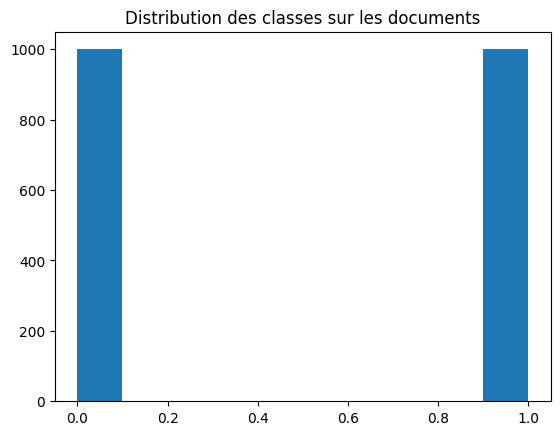

In [ ]:
get_stats(label_small)

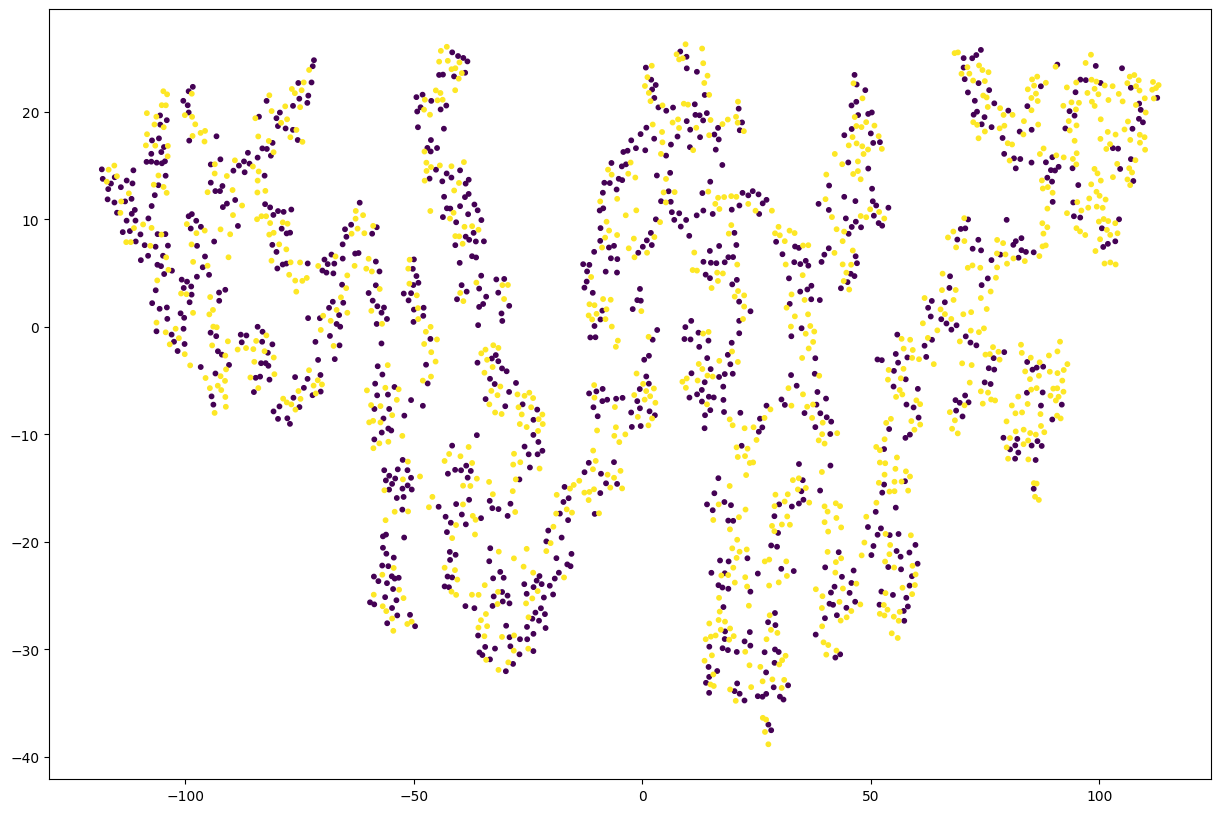

In [ ]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data_small)
get_nuage_points(vectors,label_small)

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

## Fonctions Utiles

- Dans cette stratégie , On verifie d'abord que le mot existe dans le vocabulaire (anglais ou francais), puis nous gardons dans chaque document uniquement les 3 premieres phrases et les 3 dernieres.
- Nous mettons l'hypothese que les trois premieres phrases et les trois dernieres vont reveler les sentiments du lecteur sur le film "en grande partie
- On supprime ls majuscules et les chiffres et la ponctuation

In [ ]:
liste_preprocess = [preprocess_strat1,preprocess_strat2,preprocess_strat3,preprocess_strat4,preprocess_strat5]
doc_classe_1 = data_small[label_small==0][0]
doc_classe_2 = data_small[label_small==1][0]
print("le document 1 avant toute modification :\n\n",doc_classe_1)
for i in range(len(liste_preprocess)) :
    print("------------------- PREPROCESS STRAT" + str(i+1) + "-----------------------")
    print(liste_preprocess[i](doc_classe_1))
    print("----------------------------------------------------------------------------")

le document 1 avant toute modification :

 depending on who you ask , the original sin was either the eating of the apple , the act of disobedience against god , or the act of betrayal . 
but in case you didn't know this , don't bother remembering it . . . 
the words " original sin " never come up in the movie of the same name , let alone the concept of it . 
the closest the film even gets to catholicism is in its narrative ( the story is told by angelina jolie to her priest while on death row in cuba , circa 1900 ) . 
regardless of its senseless title , original sin does actually have a plot ( albeit one of the most mangled acts of screenwriting since the art of war , based on the book waltz across darkness ) . 
boy ( antionio banderas ) places personal ad sometime around 1900 , searching for a wife . 
since this is a century ago , we narrowly dodge a remake of green card , only to find that the girl ( jolie ) faked her photo and is actually beautiful . 
skipping a few moderately usel

In [ ]:
print("le document 2 avant toute modification :\n\n",doc_classe_2)
for i in range(len(liste_preprocess)) :
    print("------------------- PREPROCESS STRAT" + str(i+1) + "-----------------------")
    print(liste_preprocess[i](doc_classe_2))
    print("----------------------------------------------------------------------------")

le document 2 avant toute modification :

  " the blair witch project " was perhaps one of a kind , a unique film that played completely on its own merit , managing to scare even the most experienced horror fans out of their senses . 
its success made a sequel inevitable , but this is not the sequel , i suspect , anyone much wanted . 
after the release of " the blair witch project " , tourists have practically invaded the small town of burkettsville , in order to get a glimpse of the blair witch . 
locals have turned this mass hysteria into a great business opportunity , selling twig-sculptures , stones and dirt like those in the movie , and the exasperated local sheriff patrols the woods with a bullhorn , shouting , " get out of these woods and go home ! 
there is no goddamned blair witch ! " . 
jeff ( ) is one of those people , who has used the sudden popularity of the small town to his advantage . 
after he got released from the mental institution , he created a mobile business that

# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [ ]:
final_stopwords_list = stopwords.words('english') + stopwords.words('french')


## 100 Mots

###  les plus frequent dans chaque document

In [ ]:
#Garder les 100 mots les plus frequent dans chaque document ( en enlevant la ponctuation et les stops words)
def get_mots_frequent_par_doc(alltxts):
    corpus = []
    punc = string.punctuation
    for doc in alltxts :
        vocab = dict()
        doc = doc.translate(str.maketrans(punc, " "* len(punc)))
        for word in doc.split() :
            if word in vocab.keys():
                vocab[word] += 1
            else :
                vocab[word]=1
        #100 mots les plus frequent
        l = sorted(vocab.items(),key = lambda x : x[1],reverse=True)
        l = filtred_stop_word(l)[: 100]
        chaine = ""
        for word in l :
            chaine += word+ " "
        corpus.append(chaine)
    return corpus

la taille du vocabulaire si on ne garde que les 100 mots les plus fréquents est :  23487


(-0.5, 399.5, 199.5, -0.5)

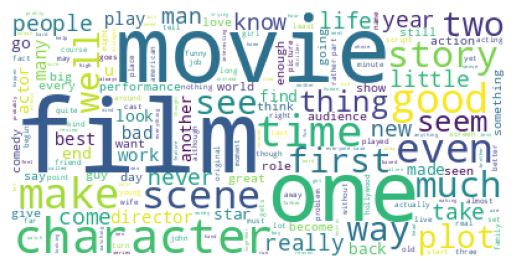

In [ ]:
corpus = get_mots_frequent_par_doc(data_small)
corpus_word = "".join(corpus)
vectorize = CountVectorizer()
X_freq = vectorize.fit_transform(corpus).toarray()
print("la taille du vocabulaire si on ne garde que les 100 mots les plus fréquents est : " ,len(vectorize.get_feature_names_out()))
#print(corpus)
wordcoud = WordCloud(background_color = "white").generate(corpus_word)

plt.figure()
plt.imshow(wordcoud)
plt.axis("off")

### frequences documentaire

les 100 mots les plus frequents dans le documents sont :
 ['the' 'and' 'of' 'to' 'is' 'in' 'it' 'that' 'as' 'with' 'film' 'his'
 'this' 'for' 'he' 'but' 'on' 'movie' 'are' 'you' 'her' 'be' 'by' 'one'
 'not' 'who' 'an' 'was' 'they' 'have' 'at' 'from' 'has' 'all' 'she'
 'there' 'so' 'like' 'about' 'out' 'what' 'up' 'their' 'more' 'which' 'or'
 'we' 'when' 'just' 'some' 'can' 'him' 'if' 'good' 'no' 'even' 'into'
 'its' 'will' 'than' 'only' 'time' 'story' 'most' 'would' 'very'
 'character' 'been' 'much' 'characters' 'well' 'get' 'do' 'also' 'two'
 'them' 'other' 'see' 'first' 'life' 'really' 'plot' 'because' 'after'
 'me' 'bad' 'my' 'films' 'too' 'way' 'make' 'any' 'had' 'action' 'off'
 'does' 'little' 'people' 'how' 'man']


(-0.5, 399.5, 199.5, -0.5)

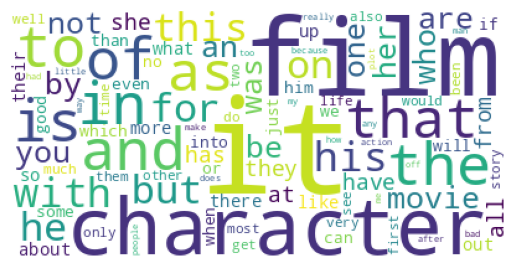

In [ ]:
vectorizer = TfidfVectorizer()
X_freq_doc = vectorizer.fit_transform(data_small)
freq = X_freq_doc.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq :
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

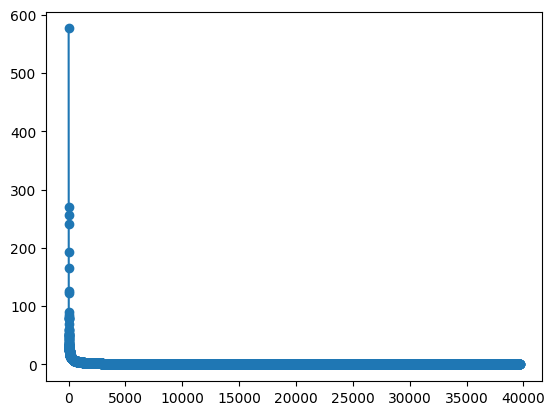

In [ ]:
indice = np.argsort(-freq)
freq = freq[indice]
plt.plot(range(len(freq)),freq,marker ='o')

### Odds Ratio

['humvee', 'humping', 'humphry', 'humphries', 'humphrey', 'humpback', 'humpalot', 'humours', 'humors', 'humorist', 'humoring', 'humongous', 'hummm', 'hummingbird', 'huns', 'huntington', 'huntz', 'hur', 'huy', 'huxley', 'hutter', 'hutt', 'hutchison', 'hutchinson', 'hut', 'hustles', 'hustled', 'hustle', 'hussein', 'hummer', 'husk', 'hurtle', 'hurtful', 'hurriedly', 'hurried', 'hurricanes', 'hurricaine', 'hurray', 'hurrah', 'hurled', 'hurl', 'hurd', 'hushes', 'hummable', 'humility', 'humiliations', 'hughton', 'hugging', 'huggies', 'huggers', 'hugger', 'hugged', 'huggan', 'huggable', 'hugeness', 'huffs', 'huey', 'hugs', 'huevelman', 'huerta', 'hue', 'hudreds', 'hudgeons', 'huddleston', 'huddled', 'hucksters', 'huckster', 'huckleberry', 'hubris', 'hubley', 'hues', 'hubbub', 'hugues', 'huiessan', 'humiliates', 'humidity', 'humid', 'humerous', 'humbug', 'humbler', 'humbled', 'humble', 'humbert', 'humanoids', 'humanoid', 'hui', 'humanness', 'humanizes', 'humanized', 'humanize', 'humanistic', '

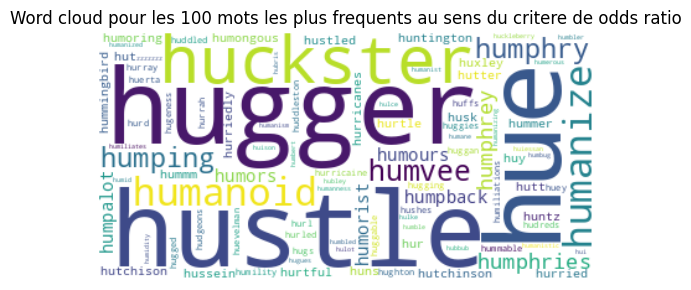

In [ ]:
def get_Wordcloud_odds_ratio(X,labels_films):
    X_0 = X[np.where(labels_films == 0)[0]]
    X_1 = X[np.where(labels_films == 1)[0]]

    frequencies_0 = [np.sum(X_0[:,i]) for i in range(X_0.shape[1])]
    frequencies_1 = [np.sum(X_0[:,i]) for i in range(X_0.shape[1])]

    odds_ratio = [np.log((frequencies_0[i]*(1 - frequencies_1[i])) / (frequencies_1[i]*(1 - frequencies_0[i]))) for i in range(len(frequencies_0))]
    ind_freq = np.argsort(odds_ratio)[-100:]
    mots_freq3 = [vectorizer.get_feature_names_out()[i] for i in ind_freq]
    print(mots_freq3)

    w_cloud = ""
    for elem in mots_freq3:
        w_cloud += str(elem)+" "

    wordcloud = WordCloud(background_color='White').generate(w_cloud)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Word cloud pour les 100 mots les plus frequents au sens du critere de odds ratio")
    plt.axis("off")
    plt.show()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_small)
get_Wordcloud_odds_ratio(X,label_small)

# Binary BOW

les 100 mots les plus frequents dans le documents sont :
 ['one' 'film' 'movie' 'like' 'even' 'time' 'good' 'much' 'would' 'get'
 'well' 'story' 'also' 'two' 'first' 'character' 'make' 'way' 'see'
 'characters' 'little' 'director' 'plot' 'could' 'really' 'best' 'people'
 'never' 'films' 'life' 'man' 'another' 'many' 'scene' 'scenes' 'bad'
 'new' 'made' 'know' 'go' 'end' 'movies' 'back' 'something' 'makes' 'work'
 'still' 'great' 'seems' 'around' 'better' 'take' 'every' 'enough' 'love'
 'however' 'big' 'us' 'gets' 'though' 'audience' 'long' 'seen' 'going'
 'real' 'year' 'role' 'look' 'years' 'world' 'old' 'last' 'come' 'things'
 'performance' 'nothing' 'right' 'think' 'almost' 'thing' 'say' 'plays'
 'fact' 'may' 'comes' 'ever' 'find' 'actually' 'action' 'since' 'screen'
 'cast' 'played' 'script' 'without' 'takes' 'acting' 'part' 'least'
 'although']


(-0.5, 399.5, 199.5, -0.5)

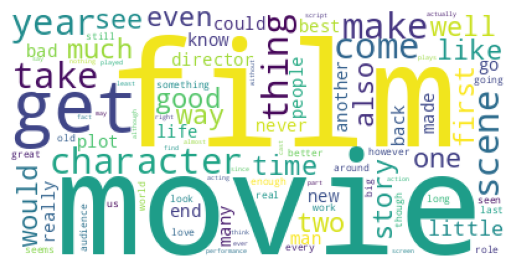

In [ ]:
vectorizer = CountVectorizer(stop_words = final_stopwords_list,binary=True)
bow_binary = vectorizer.fit_transform(data_small)
freq = bow_binary.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq :
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

## Bigramme

In [ ]:
vectorize  = TfidfVectorizer(ngram_range=(2,2))
X = vectorize.fit_transform(data_small)
freq = X.sum(axis=0).A1
indice = np.argsort(-freq)[:100]
print("les bigramme les plus frequent sont : \n", np.array(vectorize.get_feature_names_out())[indice])

les bigramme les plus frequent sont : 
 ['of the' 'in the' 'the film' 'the movie' 'to be' 'to the' 'and the'
 'on the' 'it is' 'this film' 'with the' 'for the' 'one of' 'is the'
 'as the' 'from the' 'this movie' 'at the' 'this is' 'that the' 'by the'
 'the story' 'of his' 'he is' 'out of' 'in this' 'film is' 'the first'
 'there is' 'the most' 'have been' 'if you' 'is not' 'to see' 'that he'
 'the same' 'there are' 'but it' 'all the' 'that it' 'to make' 'but the'
 'it was' 'of this' 'into the' 'that is' 'the end' 'the plot' 'and his'
 'is that' 'the only' 'the best' 'the audience' 'about the' 'to get'
 'to do' 'they are' 'in his' 'and it' 'the characters' 'movie is'
 'of course' 'more than' 'would be' 'some of' 'the way' 'with his'
 'who is' 'trying to' 'at least' 'the two' 'the other' 'most of'
 'played by' 'is an' 'the world' 'which is' 'has been' 'he has' 'all of'
 'seems to' 'special effects' 'kind of' 'when the' 'to have' 'as well'
 'lot of' 'have to' 'the original' 'going to' 'the

## Trigramme

In [ ]:
vectorize  = TfidfVectorizer(ngram_range=(3,3))
X = vectorize.fit_transform(data_small)
freq = X.sum(axis=0).A1
indice = np.argsort(-freq)[:100]
print("les trigramme les plus frequent sont : \n", np.array(vectorize.get_feature_names_out())[indice])

les trigramme les plus frequent sont : 
 ['one of the' 'of the film' 'in the film' 'the film is' 'of the movie'
 'some of the' 'the rest of' 'the fact that' 'in this film' 'the movie is'
 'rest of the' 'most of the' 'this film is' 'in the movie' 'is one of'
 'of the most' 'the end of' 'in order to' 'out of the' 'in this movie'
 'as well as' 'could have been' 'seems to be' 'at the end' 'this is the'
 'this movie is' 'to be the' 'part of the' 'of the best' 'end of the'
 'there is no' 'supposed to be' 'one of those' 'in the end' 'all of the'
 'the story is' 'in the first' 'would have been' 'of this film'
 'in love with' 'the special effects' 'the plot is' 'on the other'
 'of the characters' 'of the story' 'the story of' 'of the year'
 'the film and' 'out to be' 'if you re' 'in the middle' 'based on the'
 'the film was' 'the middle of' 'the other hand' 'to do with' 'is that it'
 'the kind of' 'be able to' 'that it is' 'it is the' 'the characters are'
 'but it is' 'that the film' 'the actin

##   Performances : avantages et les inconvénients des ces variantes

- Pour le model binaire : bonne performance lorsque la presence d'un mot ou non est plus descriminante que la fréquence de ce mot, son principale inconvenient est qu'elle ne prend pas en compte la frequence du mot, par exemple un document qui contient un mot 50 fois va etre représenter de la meme maniere qu'un document qui en a qu'un seul, alors qu'ils sont trés differents
- Bi-gramme, tri-gramme : capture la relation sémantique entre les mots, mais l'incovénient est que si on avait beaucoup de dimension au début, cette derniere accroitera d'une maniere trés grande ce qui rends le model complex

- Réduire la taille du vocabulaire : l'avantage principale est qu'il permet de réduire la dimension du vocabulaire ce qui rends le model moins complex, cepandant, on peut éléminer des mots descriminant pour un document, donc une perte d'information trés importante
- TF-IDF : le plus grand avantage c'est qu'il detecte les mots les plus descriminant dans chaque document par rapport au corpus, cepandant, il peut attribuer des poids importants pour des mots rares qui n'ont pas de signification précise pour un genre de document

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données :
- Accuracy
- Courbe ROC, AUC, F1-score

#### Création des vectorizer

In [ ]:
liste_starts = [preprocess_strat1,preprocess_strat2,preprocess_strat3,preprocess_strat4,preprocess_strat5,preprocess_strat6]
liste_Cvectorizer = [CountVectorizer(stop_words=final_stopwords_list)]

for strat in liste_starts:
    liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = strat,max_df = 0.95, min_df = 4))

liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3, ngram_range = (2,2),max_features=10000))
liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat1, ngram_range = (3,3),max_features= 10000))
# start3 for stemmed data
liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3,max_df = 0.95, min_df = 4))

#### TF-IDF

In [ ]:
liste_TFvectorizer = [TfidfVectorizer(stop_words=final_stopwords_list)]

for strat in liste_starts:
    liste_TFvectorizer.append(TfidfVectorizer(stop_words=final_stopwords_list, preprocessor = strat,max_df = 0.95, min_df = 4))
# start3 for stemmed data
liste_TFvectorizer.append(TfidfVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3,max_df = 0.95, min_df = 4))

In [ ]:
# Split sur le data small
X_train, X_test, y_train, y_test = train_test_split(data_small, label_small, test_size=0.2)
# Le data large etant deja splité

#### Fit Vectorizer

In [ ]:
liste_X_train_C = []
liste_X_train_TF = []
for i,vect in tqdm(enumerate(liste_Cvectorizer[:3])):
    liste_X_train_C.append(vect.fit_transform(X_train))
    liste_X_train_TF.append(liste_TFvectorizer[i].fit_transform(X_train))

3it [00:09,  3.28s/it]


In [ ]:
data_small_stemmed = database_stemming(X_train)
for vect in tqdm(liste_Cvectorizer[3:]):
    liste_X_train_C.append(vect.fit_transform(data_small_stemmed))
for vect in tqdm(liste_TFvectorizer[3:]):
    liste_X_train_TF.append(vect.fit_transform(data_small_stemmed))

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


#### Transformation données de test selon les vectorizers entrainée

In [ ]:
liste_X_test_C = []
liste_X_test_TF = []

for vect in tqdm(liste_Cvectorizer):
    liste_X_test_C.append(vect.transform(X_test))

for vect in tqdm(liste_TFvectorizer):
    liste_X_test_TF.append(vect.transform(X_test))

100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


# Optimisation et Apprentissage

## Linaire SVM

### CountVectorizer

In [ ]:
liste_score_C_linsvm = []
parameters = {'C':[0.001,0.01, 0.1]}
for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    svc = LinearSVC()
    gridSCV = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    gridSCV.fit(X_train,y_train)
    best_svc = gridSCV.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_C_linsvm.append((best_svc,accuracy_score(y_test,y_pred)))

10it [00:07,  1.35it/s]


In [ ]:
print(liste_score_C_linsvm)

[(LinearSVC(C=0.001), 0.845), (LinearSVC(C=0.001), 0.8425), (LinearSVC(C=0.001), 0.8425), (LinearSVC(C=0.001), 0.785), (LinearSVC(C=0.001), 0.7825), (LinearSVC(C=0.001), 0.7825), (LinearSVC(C=0.001), 0.7825), (LinearSVC(C=0.001), 0.705), (LinearSVC(C=0.001), 0.455), (LinearSVC(C=0.001), 0.785)]


### TF-IDF

In [ ]:
liste_score_TF_linsvm = []
parameters = {'C':[0.01, 0.1, 1.5,2]}
for i,X_train in tqdm(enumerate(liste_X_train_TF)) :
    X_test = liste_X_test_TF[i]
    svc = LinearSVC()
    clf = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    clf.fit(X_train,y_train)
    best_svc = clf.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_TF_linsvm.append((best_svc,accuracy_score(y_test,y_pred)))

8it [00:05,  1.48it/s]


In [ ]:
print(liste_score_TF_linsvm)

[(LinearSVC(C=0.01), 0.7225), (LinearSVC(C=0.01), 0.7475), (LinearSVC(C=0.01), 0.7475), (LinearSVC(C=0.01), 0.715), (LinearSVC(C=0.01), 0.715), (LinearSVC(C=0.01), 0.715), (LinearSVC(C=0.01), 0.715), (LinearSVC(C=0.01), 0.715)]


## SVM

In [ ]:
liste_score_C_svm = []
parameters = {'C':[0.01, 0.1, 1.2]}
for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    svc = svm.SVC()
    gridSCV = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    gridSCV.fit(X_train,y_train)
    best_svc = gridSCV.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_C_svm.append((best_svc,accuracy_score(y_test,y_pred)))

10it [05:19, 31.98s/it]


In [ ]:
print(liste_score_C_svm)

[(SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475)]


In [ ]:
liste_score_TF_svm = []
parameters = {'C':[0.01, 0.1, 1.5,2]}
for i,X_train in tqdm(enumerate(liste_X_train_TF)) :
    X_test = liste_X_test_TF[i]
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, cv=3, scoring=metrique_globale)
    clf.fit(X_train,y_train)
    best_svc = clf.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_TF_svm.append((best_svc,accuracy_score(y_test,y_pred)))

8it [06:30, 48.75s/it]


In [ ]:
print(liste_score_TF_svm)

[(SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475), (SVC(C=0.01), 0.4475)]


## REGRESSION LOGISTIQUE

### CountVectorizer

In [ ]:
liste_score_C_lr = []
hyperparameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}

for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    lr = LogisticRegression(max_iter= 1000)

    gridSCV = GridSearchCV(lr, hyperparameters, cv=3,scoring=metrique_globale)
    gridSCV.fit(X_train,y_train)
    best_params = gridSCV.best_params_

    best_lr = LogisticRegression(**best_params, max_iter= 1000)
    best_lr.fit(X_train, y_train)
    y_pred = best_lr.predict(X_test)
    liste_score_C_lr.append((best_lr,accuracy_score(y_test,y_pred)))

10it [00:31,  3.16s/it]


In [ ]:
print(liste_score_C_lr)

[(LogisticRegression(C=0.001, max_iter=1000), 0.8075), (LogisticRegression(C=0.001, max_iter=1000), 0.81), (LogisticRegression(C=0.001, max_iter=1000), 0.81), (LogisticRegression(C=0.001, max_iter=1000), 0.71), (LogisticRegression(C=0.001, max_iter=1000), 0.715), (LogisticRegression(C=0.001, max_iter=1000), 0.715), (LogisticRegression(C=0.001, max_iter=1000), 0.715), (LogisticRegression(C=0.001, max_iter=1000), 0.4875), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.71)]


### TF - IDF

In [ ]:
liste_score_TF_lr = []
hyperparameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}

for i, X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    lr = LogisticRegression(max_iter= 1000)

    gridSCV = GridSearchCV(lr, hyperparameters, cv=3,scoring=metrique_globale)
    gridSCV.fit(X_train,y_train)
    best_params = gridSCV.best_params_

    best_lr = LogisticRegression(**best_params, max_iter= 1000)
    best_lr.fit(X_train, y_train)
    y_pred = best_lr.predict(X_test)
    liste_score_TF_lr.append((best_lr,accuracy_score(y_test,y_pred)))

8it [00:09,  1.25s/it]


In [ ]:
print(liste_score_TF_lr)

[(LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475), (LogisticRegression(C=0.001, max_iter=1000), 0.4475)]


## Arbre de decision

## Vectorizer

In [ ]:
liste_score_C_tree = []
param_grid = {
    'max_depth': [5, 10, 13, None],
    'min_samples_split': [2, 5, 10]
}
for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, y_train)
    best_rfc = grid_search.best_estimator_
    y_pred = best_rfc.predict(X_test)
    liste_score_C_tree.append((best_rfc,accuracy_score(y_test, y_pred)))

10it [02:12, 13.25s/it]


In [ ]:
print(liste_score_C_tree)

[(RandomForestClassifier(max_depth=5), 0.7775), (RandomForestClassifier(max_depth=5), 0.7925), (RandomForestClassifier(max_depth=5), 0.78), (RandomForestClassifier(max_depth=5), 0.575), (RandomForestClassifier(max_depth=5), 0.6675), (RandomForestClassifier(max_depth=5), 0.5775), (RandomForestClassifier(max_depth=5), 0.6475), (RandomForestClassifier(max_depth=5), 0.55), (RandomForestClassifier(max_depth=5), 0.445), (RandomForestClassifier(max_depth=5), 0.6175)]


## IF-IDF

In [ ]:
liste_score_TF_tree = []
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

for i, X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, y_train)
    best_rfc = grid_search.best_estimator_
    y_pred = best_rfc.predict(X_test)
    liste_score_TF_tree.append((best_rfc,accuracy_score(y_test, y_pred)))

8it [02:05, 15.72s/it]


In [ ]:
print(liste_score_TF_tree)

[(RandomForestClassifier(max_depth=5), 0.755), (RandomForestClassifier(max_depth=5), 0.785), (RandomForestClassifier(max_depth=5), 0.785), (RandomForestClassifier(max_depth=5), 0.735), (RandomForestClassifier(max_depth=5), 0.7525), (RandomForestClassifier(max_depth=5), 0.745), (RandomForestClassifier(max_depth=5), 0.75), (RandomForestClassifier(max_depth=5), 0.755)]


## Naive Bayes

### Vectorizer

In [ ]:
liste_score_C_nb = []
param_grid = {
    'alpha': [0.1, 0.5, 1, 2],
    'fit_prior': [True, False]
}

for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, y_train)
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, y_train)
    y_pred = best_nb.predict(X_test)
    liste_score_C_nb.append((best_nb, accuracy_score(y_test, y_pred)))


10it [00:01,  8.32it/s]


In [ ]:
print(liste_score_C_nb)

[(MultinomialNB(alpha=0.1), 0.79), (MultinomialNB(alpha=0.1), 0.82), (MultinomialNB(alpha=0.1), 0.82), (MultinomialNB(alpha=0.1), 0.7525), (MultinomialNB(alpha=0.1), 0.7625), (MultinomialNB(alpha=0.1), 0.7625), (MultinomialNB(alpha=0.1), 0.7625), (MultinomialNB(alpha=0.1), 0.735), (MultinomialNB(alpha=0.1), 0.58), (MultinomialNB(alpha=0.1), 0.7525)]


## TF-IDF

In [ ]:
liste_score_TF_nb = []
param_grid = {
    'alpha': [0.1, 0.5, 1, 2],
    'fit_prior': [True, False]
}

for i,X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=2, scoring=metrique_globale)
    grid_search.fit(X_train, y_train)
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, y_train)
    y_pred = best_nb.predict(X_test)
    liste_score_TF_nb.append((best_nb, accuracy_score(y_test, y_pred)))


8it [00:01,  6.38it/s]


In [ ]:
print(liste_score_TF_nb)

[(MultinomialNB(alpha=0.1), 0.8075), (MultinomialNB(alpha=0.1), 0.81), (MultinomialNB(alpha=0.1), 0.81), (MultinomialNB(alpha=0.1), 0.7625), (MultinomialNB(alpha=0.1), 0.76), (MultinomialNB(alpha=0.1), 0.76), (MultinomialNB(alpha=0.1), 0.76), (MultinomialNB(alpha=0.1), 0.7625)]


#TRANSFORMERS

In [22]:
BATCH_SIZE = 32
EPOCHS  = 10
NB_CLASSES = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_small, label_small, test_size=0.2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
def tokenize_data(texts, labels, max_length=256):
    input_ids = []
    attention_masks = []
    for text in texts :
      encoded_dict = tokenizer.encode_plus(
      text,
      add_special_tokens = True, #CLS PES
      pad_to_max_length=True,
      truncation=True,
      max_length = max_length,
      return_attention_mask = True,
      return_tensors = 'pt'

      )
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
    ids = torch.cat(input_ids,dim = 0)
    mask = torch.cat(attention_masks,dim = 0)
    return TensorDataset(ids,mask,torch.tensor(labels))


In [ ]:
#X_train_Pret = [text) for text in X_train]
dataset = tokenize_data(X_train, y_train)
test_dataset = tokenize_data(X_test, y_test)
train_dataloader = DataLoader(dataset, shuffle = True, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle = False, batch_size = BATCH_SIZE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
for param in model.bert.parameters() :
  param.requires_grad = False

In [ ]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
model = model.to(device)
for epoch in range(EPOCHS)  :
  tqdm_train_dataloader = tqdm(train_dataloader,desc = f'Epoch = {epoch+1} / {EPOCHS}')
  acc_accuracy_train = 0
  acc_accuracy_test = 0
  acc_loss_train = 0
  acc_loss_test = 0
  model.train()
  for id,mask,label in tqdm_train_dataloader :
    id = id.to(device)
    mask = mask.to(device)
    label = label.to(device)
    outputs = model(id, attention_mask = mask,labels = label)
    loss = outputs.loss
    acc_loss_train += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc_accuracy_train += accuracy(torch.argmax(outputs.logits,dim = 1),label,task = 'Binary')
  loss_train.append(acc_loss_train)
  accuracy_train.append(acc_accuracy_train/len(train_dataloader))

  with torch.no_grad() :
    for id,mask,label in test_dataloader :
      id = id.to(device)
      mask = mask.to(device)
      label = label.to(device)
      outputs = model(id, attention_mask = mask,labels = label)
      loss = outputs.loss
      acc_loss_test += loss.item()
      acc_accuracy_test += accuracy(torch.argmax(outputs.logits,dim = 1),label,task = 'Binary')
    loss_test.append(acc_loss_test)
    accuracy_test.append(acc_accuracy_test/len(test_dataloader))




Epoch = 10 / 10: 100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


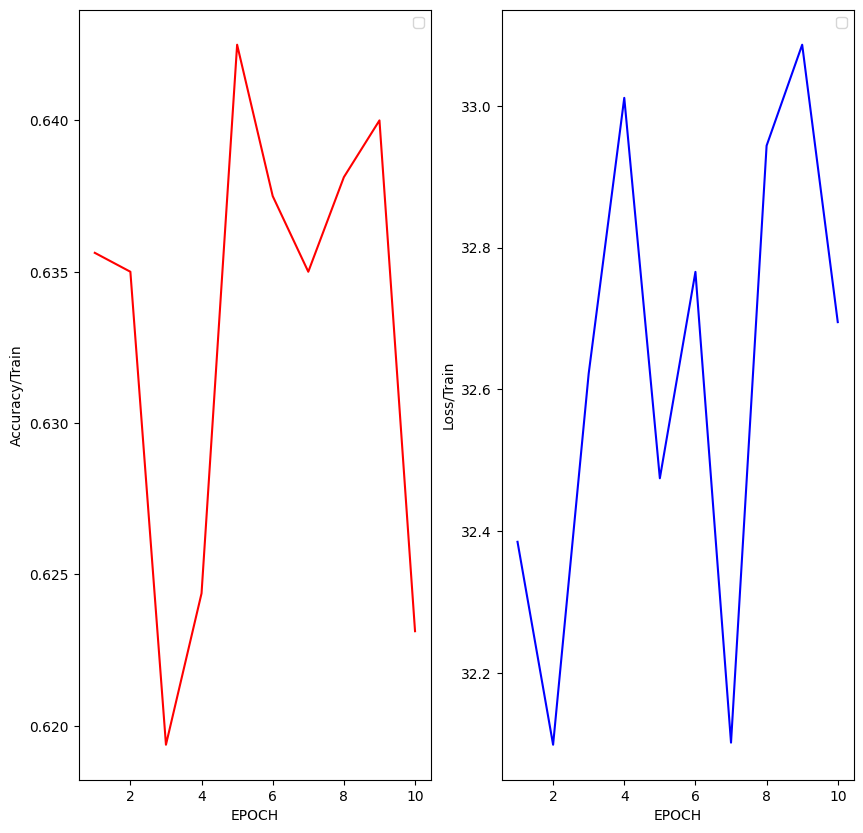

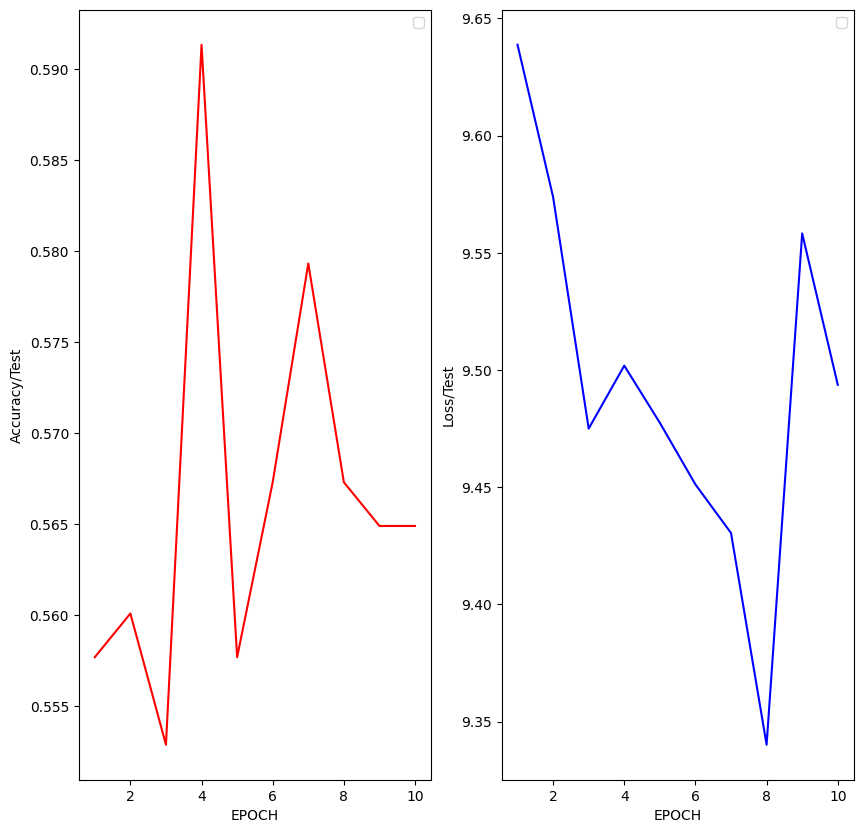

In [ ]:
axis = range(1,EPOCHS+1)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_test = [acc.item() for acc in accuracy_test]

#liste_loss_train = [loss.item() for loss in loss_train]
plt.subplot(1,2,1)
plt.plot(axis,list_acc_train,c='red')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy/Train")
plt.legend()


plt.subplot(1,2,2)
plt.plot(axis,loss_train,c='blue')
plt.xlabel("EPOCH")
plt.ylabel("Loss/Train")
plt.legend()
plt.show()

plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(axis,list_acc_test,c='red')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy/Test")
plt.legend()


plt.subplot(1,2,2)
plt.plot(axis,loss_test,c='blue')
plt.xlabel("EPOCH")
plt.ylabel("Loss/Test")
plt.legend()



#RNN

In [8]:
batch_size = 32
EPOCHS  = 10
vocab_size = 10000  # Taille du vocabulaire
Dim_embed = 100
Dim_lat = 120
Dim_out = 2

In [9]:
def filter_stop_word(phrase):
  stop_words = set(stopwords.words('english'))

  # Tokenisation de la phrase
  mots = word_tokenize(phrase)

  # Filtrer les stop words
  phrase_filtrée = [mot for mot in mots if mot not in stop_words]

  # Reconstituer la phrase
  phrase_sans_stop_words = ' '.join(phrase_filtrée)
  return phrase_sans_stop_words

In [11]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
class RNNClassifier(nn.Module):
  def __init__(self,vocab_size, Dim_embed,Dim_lat,Dim_out) :
    super().__init__()
    self.Dim_embed = Dim_embed
    self.Dim_lat = Dim_lat
    self.Dim_out = Dim_out
    self.embedding = nn.Embedding(vocab_size,Dim_embed)
    self.rnn = nn.RNN(Dim_embed,Dim_lat, batch_first = True)
    self.classifier = nn.Linear(Dim_lat,Dim_out)

  def forward(self,text) :
    embeded = self.embedding(text)
    _,hidden = self.rnn(embeded)
    hidden = hidden.squeeze(0)
    result = self.classifier(hidden)
    return result


In [19]:
def tokenize(texts, vocab_size):
    tokenized_texts = []
    word_counts = Counter(word for text in texts for word in text.split())
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)[:vocab_size]
    word_to_index = {word: index + 1 for index, word in enumerate(vocab)}  # +1 POUR PADDING

    for text in texts:
        tokenized_text = [word_to_index.get(word, 0) for word in text.split()]
        tokenized_texts.append(tokenized_text)

    return tokenized_texts, word_to_index
data_small = [filter_stop_word(text) for text in data_small]
data_small_p = [preprocess_strat4(text) for text in data_small]
tokenized_texts, word_to_index = tokenize(data_small_p, vocab_size)

max_length = max(len(text) for text in tokenized_texts)
padded_texts = np.zeros((len(tokenized_texts), max_length), dtype=int)
for i, text in enumerate(tokenized_texts):
    padded_texts[i, :len(text)] = text

# Encodage des étiquettes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_small)


X_train, X_test, y_train, y_test = train_test_split(padded_texts, encoded_labels, test_size=0.2)
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_classifier = RNNClassifier(vocab_size + 1 , Dim_embed,Dim_lat,Dim_out)
optimizer = torch.optim.Adam(rnn_classifier.parameters(),lr = 1e-3)
criterion = nn.CrossEntropyLoss()
rnn_classifier = rnn_classifier.to(device)
for epoch in range(EPOCHS):
  total_loss = 0
  tqdm_train_loader = tqdm(train_loader,desc = f'Epoch = {epoch+1} / {EPOCHS}')
  acc_accuracy_train = 0
  acc_accuracy_test = 0
  acc_loss_test = 0
  for texts, labels in tqdm_train_loader:
      texts = texts.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = rnn_classifier(texts)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      acc_accuracy_train += accuracy(torch.argmax(output,dim = 1),labels,task = 'Binary')
  loss_train.append(total_loss)
  accuracy_train.append(acc_accuracy_train/len(train_loader))

  with torch.no_grad() :
    for texts, labels in test_loader :
      texts = texts.to(device)
      labels = labels.to(device)
      output = rnn_classifier(texts)
      loss = criterion(output, labels)
      acc_loss_test += loss.item()
      acc_accuracy_test += accuracy(torch.argmax(output,dim = 1),labels,task = 'Binary')
    loss_test.append(acc_loss_test)
    accuracy_test.append(acc_accuracy_test/len(test_loader))


Epoch = 10 / 10: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


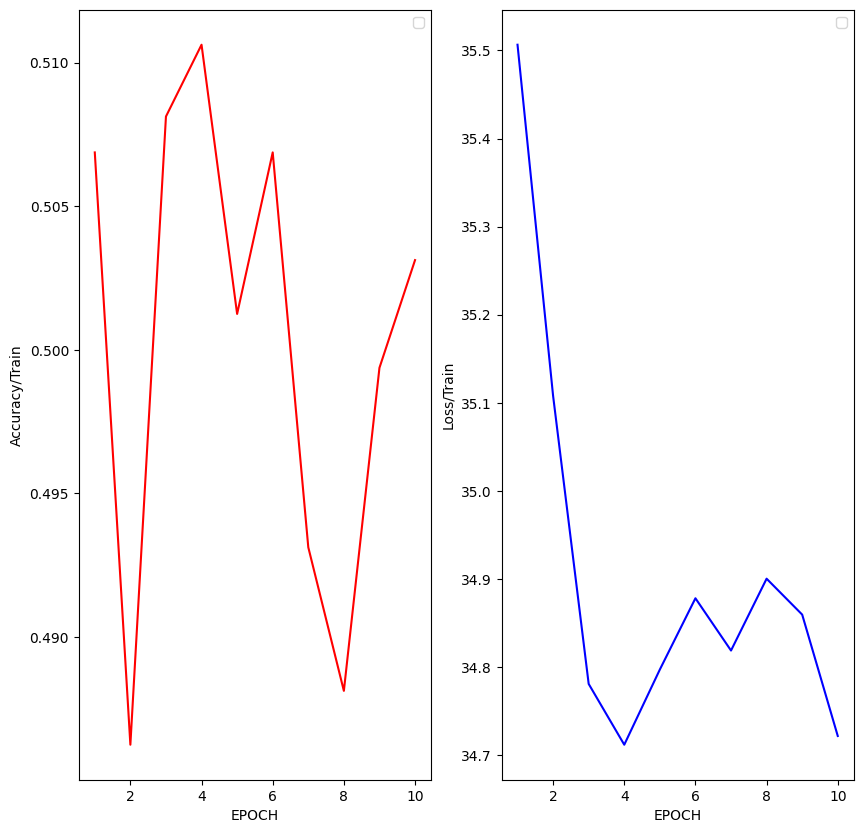

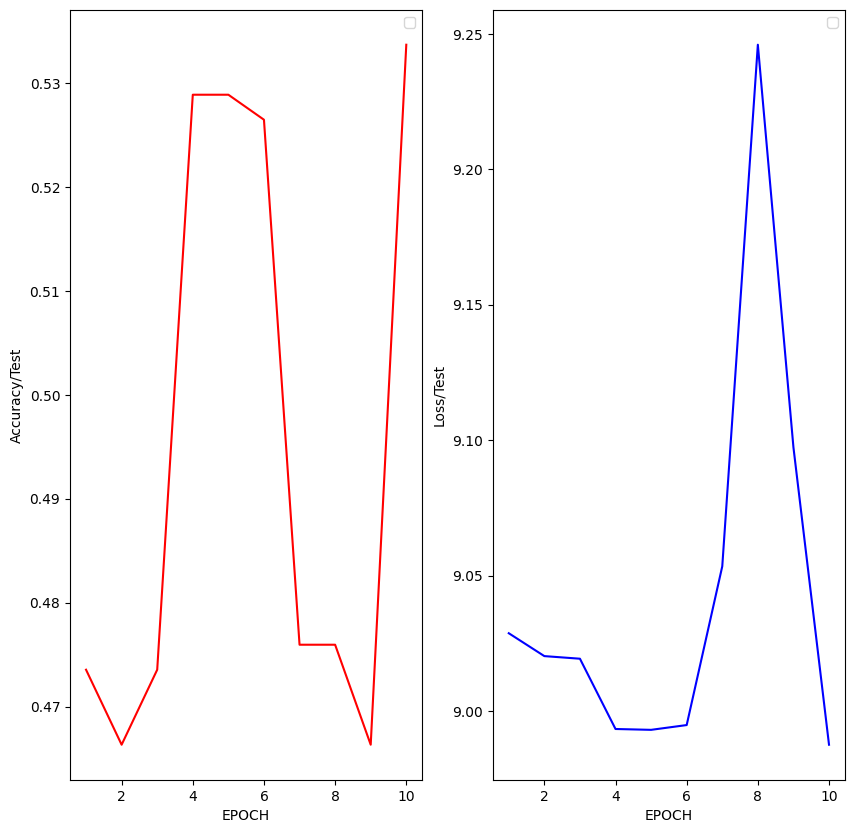

In [ ]:
axis = range(1,EPOCHS+1)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_test = [acc.item() for acc in accuracy_test]

#liste_loss_train = [loss.item() for loss in loss_train]
plt.subplot(1,2,1)
plt.plot(axis,list_acc_train,c='red')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy/Train")
plt.legend()


plt.subplot(1,2,2)
plt.plot(axis,loss_train,c='blue')
plt.xlabel("EPOCH")
plt.ylabel("Loss/Train")
plt.legend()
plt.show()

plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(axis,list_acc_test,c='red')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy/Test")
plt.legend()


plt.subplot(1,2,2)
plt.plot(axis,loss_test,c='blue')
plt.xlabel("EPOCH")
plt.ylabel("Loss/Test")
plt.legend()



#LSTM

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, Dim_embed, Dim_lat, Dim_out):
        super().__init__()
        self.Dim_embed = Dim_embed
        self.Dim_lat = Dim_lat
        self.Dim_out = Dim_out
        self.embedding = nn.Embedding(vocab_size, Dim_embed)
        self.lstm = nn.LSTM(Dim_embed, Dim_lat, batch_first=True,bidirectional=True)
        self.classifier = nn.Linear(Dim_lat * 2, Dim_out)

    def forward(self, text):
        embeded = self.embedding(text)
        _, (hidden, _) = self.lstm(embeded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Prendre le dernier état caché
        result = self.classifier(hidden)
        return result


In [25]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
EPOCHS = 20

lstm_classifier = LSTMClassifier(vocab_size + 1 , Dim_embed,Dim_lat,Dim_out)
optimizer = torch.optim.Adam(lstm_classifier.parameters(),lr = 1e-3)
criterion = nn.CrossEntropyLoss()
lstm_classifier = lstm_classifier.to(device)
for epoch in range(EPOCHS):
  total_loss = 0
  tqdm_train_loader = tqdm(train_loader,desc = f'Epoch = {epoch+1} / {EPOCHS}')
  acc_accuracy_train = 0
  test_acc_accuracy = 0
  total_loss_test = 0
  for texts, labels in tqdm_train_loader:
      texts = texts.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = lstm_classifier(texts)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      acc_accuracy_train += accuracy(torch.argmax(output,dim = 1),labels,task = 'Binary')
  loss_train.append(total_loss)
  accuracy_train.append(acc_accuracy_train/len(train_loader))

  with torch.no_grad() :
    for textsTest, labelsTest in test_loader :
      textsTest = textsTest.to(device)
      labelsTest = labelsTest.to(device)
      outputTest = lstm_classifier(textsTest)
      lossTest = criterion(outputTest, labelsTest)
      total_loss_test += lossTest.item()
      test_acc_accuracy += accuracy(torch.argmax(outputTest,dim = 1),labelsTest,task = 'Binary')
    loss_test.append(total_loss_test)
    accuracy_test.append(test_acc_accuracy/len(test_loader))


Epoch = 20 / 20: 100%|██████████| 50/50 [00:02<00:00, 23.64it/s]


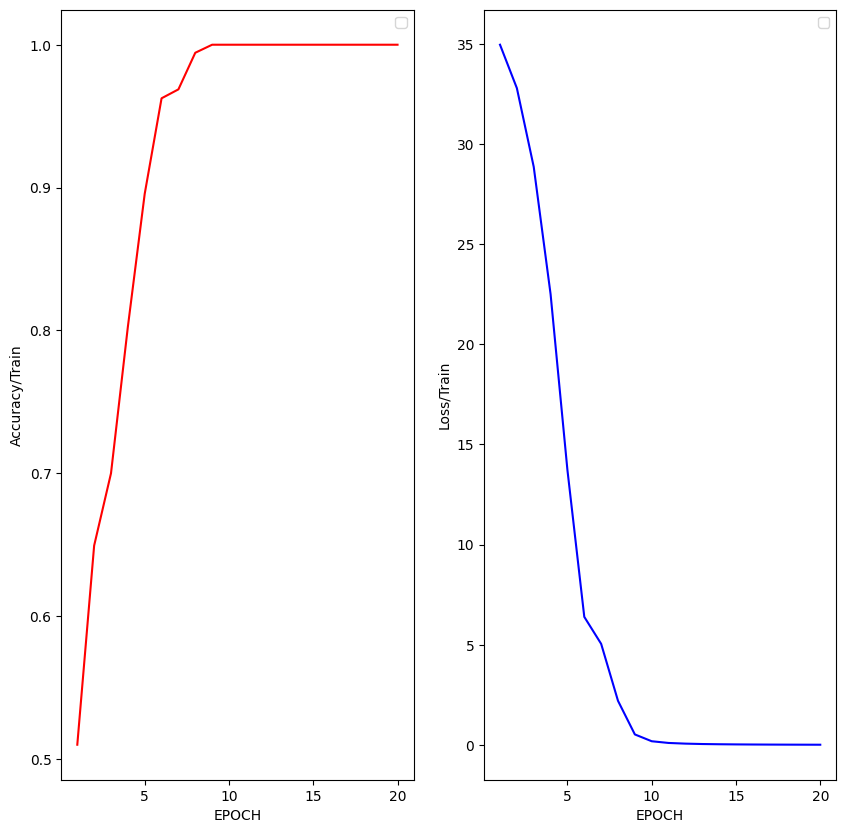

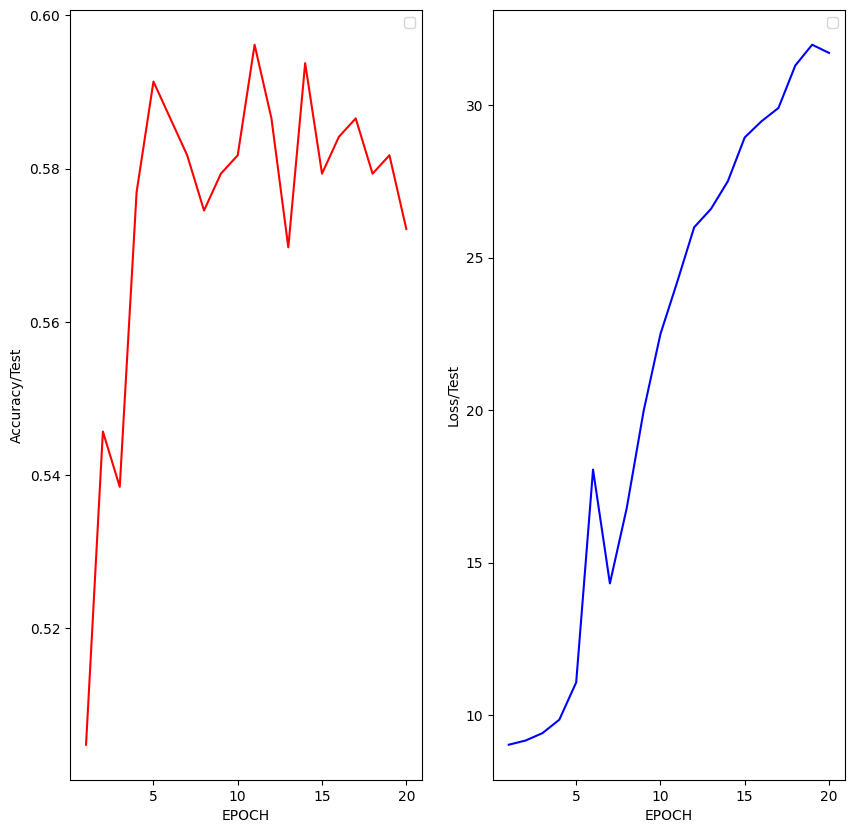

In [26]:
axis = range(1,EPOCHS+1)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_test = [acc.item() for acc in accuracy_test]

#liste_loss_train = [loss.item() for loss in loss_train]
plt.subplot(1,2,1)
plt.plot(axis,list_acc_train,c='red')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy/Train")
plt.legend()


plt.subplot(1,2,2)
plt.plot(axis,loss_train,c='blue')
plt.xlabel("EPOCH")
plt.ylabel("Loss/Train")
plt.legend()
plt.show()

plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(axis,list_acc_test,c='red')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy/Test")
plt.legend()


plt.subplot(1,2,2)
plt.plot(axis,loss_test,c='blue')
plt.xlabel("EPOCH")
plt.ylabel("Loss/Test")
plt.legend()



## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

Pour trouver les meilleurs hyperparamètres pour un modèle, nous avon décidé d'utiliser GridSearchCV sur une grille de valeurs possibles pour chaque hyperparamètre. Elle permet de sélectionner les valeurs d'hyperparamètres qui donnent les meilleurs résultats de performance pour le modèle et évite au meme temps le sur-apprentisage en utilisant La Validation - Croisée

### Equilibrage des données

Dans le début de notre expérimentation, on a visualisé les données et afficher la distribution des classes, elles sont bien équilibrées, donc ce n'est pas nécesaire, pour cette base de données de les réequilibrer


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

##### Temps d'éxecution

- NB : 1.51s/it soit 15 sec pour tester les différents vectorizer avec les differentes stratégies(Juste pour les - CountVectorizer) SVM : Beaucoup trop long, on a utilisé un SVM linéaire à la place
- SVM Linéaire : 16.33s/it soit 2min30  pour tester les différents vectorizer avec les differentes stratégies
- RegLog : 50.23s/it soit 8 min pour tester les différents vectorizer avec les differentes stratégies
- Arbre de décision : 569.91s/it soit 1h30 pour tester les différents vectorizer avec les differentes stratégies

#### Validation Croisée

- La validation croisée est recommandée pour éviter le surajustement du modèle et pour obtenir une estimation plus fiable de ses performances. elle est donc nécessaire pour obtenir une estimation précise des performances du modèle.

 #### simple split

- Un simple split peut être utilisé pour évaluer les performances d'un modèle, mais il est  considéré comme moins fiable que la validation croisée. parce que les performances du modèle peuvent varier en fonction de la manière dont les données sont divisées en ensembles d'entraînement et de test

#### Extraire le model le plus performant

In [ ]:
f = open("./datasets/movies/movie_test/testSentiment.txt","r", encoding="utf-8").read()
model = liste_score_C_linsvm[1][0]
X_train = liste_X_train_C[1]
x_eval = np.array(f.split("\n")[:-1])
x_test = liste_Cvectorizer[1].transform(x_eval)
y_pred = model.predict(x_test)
create_output_file(y_pred,name = "linSVC")